# 0. Environment Setup

- Please run the code below at the start. It fetches the bias tool from GitHub, and installs a missing package.

In [1]:
# RUN THE FOLLOWING ONCE AT THE START, IN GOOGLE COLLAB
!git clone https://github.com/robertcinca/ml_bias_study
%cd "/content/ml_bias_study"
!pip install chart-studio==1.1.0

fatal: destination path 'ml_bias_explainability' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/ml_bias_explainability'
/Users/robertcinca/Desktop/UCL/PhD/explainability_library/ml_bias_explainability
You should consider upgrading via the '/Users/robertcinca/.pyenv/versions/3.7.6/bin/python3.7 -m pip install --upgrade pip' command.


# 1. Introduction & Instructions

This study introduces you to Bias in Machine Learning (ML) whilst interacting with a bias mitigation tool. Some code is already provided. You can simply run these code snippets, however, please read them, including the comments. 

As you go through the tutorial, you will be asked to complete 11 mini exercises, these are bolded and start with the word **Exercise**. There is an optional 12th exploratory exercise at the end. Please write answers down within this notebook and share the file with us in advance of the interview.

The purpose of this activity is for us to understand how Bias is perceived within ML, and how to design tutorials and tools for Bias detection and mitigation. It is not to evaluate your ability or skills!

Please note that Colab has some limitations: a session ends after 12 hours, or if it has been idle for more than 90 minutes. All runtime data is lost once the session ends. Therefore, you may want to complete this study in one go.

To display all sections of the study, in the menubar at the top please "view" and then "expand sections".

**Exercise 1:** How would you describe what bias in machine learning is? Please write down your thoughts.

*Please single (or double) click this box and type your answer here.*

**Exercise 2:** How do issues of bias and fairness influence the way you use (or the way you would use) ML technology in your work? Please write down your thoughts.

*Please single (or double) click this box and type your answer here.*

This section contains import statements and global variables used in the tutorial

In [36]:
import os
import cufflinks as cf
import numpy as np
import pandas as pd
import plotly.io as pio
from IPython.display import Image, display
from ipywidgets import interact, interact_manual

from ml_bias_explainability.compile_model_and_analysis import CompileModelAndAnalysis
from ml_bias_explainability.find_best_parameters import FindBestParameter
from ml_bias_explainability.helpers.helper import Helper
from ml_bias_explainability.run_tool_interaction import RunInteraction

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
pio.renderers.default = "colab" # comment out if not running in Colab

# 2. Our First Dataset: COMPAS Recidivism Dataset

We will introduce concepts of bias through the help of the COMPAS dataset. The input features in this dataset are used to determine the risk of recidivism (chance of re-offending) that a criminal defendant has. This dataset is widely used within Bias Analysis as an example of a biased dataset.

In [4]:
# Variables refering to folder locations for the COMPAS dataset are defined here
"""
Path to the dataset
"""
first_dataset_csv_path = "scripts/data/1_compass_recidivism/compas-scores-two-years.csv"

"""
List of columns that need to be removed from the dataset in the pre-processing stage
"""
first_dataset_columns_to_remove = Helper.read_yaml("scripts/data/1_compass_recidivism/columns_to_remove.yml")

"""
Output folder for the analysis. This can be accessed at a later stage, 
to avoid having to re-run everything.
"""
output_folder_location = "scripts/data/1_compass_recidivism/output"

### Step 1: Loading & Understanding the Dataset

The first step is to load and clean the dataset. Have a look at the code below to get an idea of the cleaning processes that take place, and the resulting dataframe

In [5]:
# Load and clean the dataset
def clean_dataset(csv_path, columns_to_remove):
    # The dataset used is taken from https://github.com/propublica/compas-analysis
    df = pd.read_csv(csv_path, index_col=0)

    # Based on propublica analysis, filter rows where COMPAS scoring and
    # arrest date weren't within 30 days of each other
    df = df[df.days_b_screening_arrest <= 30]
    df = df[df.days_b_screening_arrest >= -30]

    # get rid of columns that shouldn't be in the input model
    filtered_columns_to_remove = df.filter(columns_to_remove)
    df.drop(filtered_columns_to_remove, inplace=True, axis=1)

    # Ensure validity of inputs – No NaNs
    object_list, numeric_list = Helper.get_df_types_list(df)
    for column in object_list:
        df[column].fillna("", inplace=True)
    for column in numeric_list:
        df[column].fillna(-1, inplace=True)

    return df

recidivism_df = clean_dataset(first_dataset_csv_path, first_dataset_columns_to_remove)
recidivism_df

,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,two_year_recid
id,,,,,,,,,,,
1,Male,69,Greater than 45,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0
3,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,1
4,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine,1
7,Male,44,25 - 45,Other,0,0,0,0,M,Battery,0
8,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools,1
...,...,...,...,...,...,...,...,...,...,...,...
10996,Male,23,Less than 25,African-American,0,0,0,0,F,Deliver Cannabis,0
10997,Male,23,Less than 25,African-American,0,0,0,0,F,Leaving the Scene of Accident,0
10999,Male,57,Greater than 45,Other,0,0,0,0,F,Aggravated Battery / Pregnant,0


Here is a brief explanation of each feature:
- sex: Male or Female
- age: ranges from 18 to 96
- age_cat: ages grouped into 3 categories: [Greater than 45, 25 - 45, Less than 25]
- race: 6 categories: [Other, African-American, Caucasian, Hispanic, Asian, Native American]
- juv_fel_count: number of felonies (serious offences) that the person committed as a juvenile (under 18). Ranges from 0 to 20.
- juv_misd_count: number of misdemeanors (less serious offences) that the person committed as a juvenile (under 18). Ranges from 0 to 13.
- juv_other_count: number of other charges (not felonies nor misdemeanors) that the person committed as a juvenile (under 18). Ranges from 0 to 9.
- priors_count: number of previous offences that the person has committed. Ranges from 0 to 38.
- c_charge_degree: whether the crime in question is a felony (F) or misdemeanor (M).
- c_charge_desc: a description of the crime that took place

- two_year_recid (output feature): whether the person in question went on to commit a crime within the next two years. 1 for yes, 0 for no.

**Exercise 3:** From the 10 input features of the dataset, which features would you say could be problematic in terms of bias and discrimination? In other words, if you were building a model with this dataset, what features would you expect to cause bias?

*Please single (or double) click this box and type your answer here.*

Before even starting on any computations, it is worth playing around with the dataset to get a feel for it. Feel free to use the next few sections to explore the dataset

In [6]:
# Interact with specification of arguments
@interact
def show_filtered_raw_data(column=recidivism_df.select_dtypes(include=[np.number]).columns, x=(0, 100, 1)):
    return recidivism_df.loc[recidivism_df[column] >= x]

interactive(children=(Dropdown(description='column', options=('age', 'juv_fel_count', 'juv_misd_count', 'juv_o…

In [7]:
# Observe the data through a scatter plot. Press "Run Interact" to start the plotting.
@interact_manual
def scatter_plot(
    x=list(recidivism_df.select_dtypes("number").columns),
    y=list(recidivism_df.select_dtypes("number").columns)[1:],
    theme=list(cf.themes.THEMES.keys()),
    colorscale=list(cf.colors._scales_names.keys()),
):

    recidivism_df.iplot(
        kind="scatter",
        x=x,
        y=y,
        mode="markers",
        xTitle=x.title(),
        yTitle=y.title(),
        title=f"Scatter Plot: {y.title()} vs {x.title()}",
        theme=theme,
        colorscale=colorscale,
    )

interactive(children=(Dropdown(description='x', options=('age', 'juv_fel_count', 'juv_misd_count', 'juv_other_…

Please note, if you want to look at any of the csv files in-depth (e.g., by opening them in Excel), feel free to do so. You can find them under the following directory: ``ml_bias_explainability/scripts/data/``. E.g., the COMPAS dataset that you have just been looking at is located at ``ml_bias_explainability/scripts/data/1_compass_recidivism/compas-scores-two-years.csv``. In there you will also see an ``output`` folder, which is where all the computed analysis goes.

### Step 2: Computing the Analysis
The second step is to use the tool to create a ML model and then compute bias statistics and visualizations related to the output. Bias concepts and definitions will be explained and inspected in the Tool Analysis section (Section 3).

In [8]:
# Firstly define the following parameters for the tool

"""
training_types tells the bias tool what modifications to apply to the dataset before running the analysis.
There are two types: original_dataset, which leaves the data unchanged and remove_feature, which runs 
the analysis on multiple datasets, each dataset having a different feature removed.
"""
training_types = [
        "original_dataset",
        "remove_feature",
    ]

"""
features_of_interest are user-defined input features that are at risk of bias or discrimination. 
The "all" setting shows the overall metrics for the dataset.
"""
features_of_interest = ["all", "race", "sex", "age_cat"]

"""
This defines the output feature, the rest of the features will be deemed as input features.
"""
output = "two_year_recid"

"""
This is a threshold for the tool to use when defining categorical vs numerical features. 
Keeping this value low will make the analysis run faster, at the expense of granularity.
"""
unique_values = 6

"""
Setting Verbose to True will result in additional textual explanations highlighting areas with potential bias.
"""
verbose = False

"""
Setting parameters for the trained Neural Network model.
"""
best_params = dict(
    batch_size=128,
    epochs=15,
    optimizer="Nadam",
    init_mode="he_uniform",
    activation="sigmoid",
    weight_constraint=1,
    dropout_rate=0.2,
    neurons=128,
    hidden_layers=4,
)

In [9]:
# Running the analysis itself
(
    model_evaluation_df,
    raw_predictions_df,
    predictions_change_df,
    volatility_df,
    sensitivity_evaluation_df,
) = CompileModelAndAnalysis(
    training_types,
    features_of_interest,
    output,
    first_dataset_columns_to_remove,
    first_dataset_csv_path,
    None,
    unique_values,
    best_params,
).main(
    recidivism_df
)

RUNNING ANALYSIS FOR TRAINING TYPE: 'original_dataset'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 1s 12ms/step - loss: 0.7338 - accuracy: 0.5042 - val_loss: 0.6915 - val_accuracy: 0.5202
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5181 - val_loss: 0.6857 - val_accuracy: 0.5233
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5536 - val_loss: 0.6629 - val_accuracy: 0.6387
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6161 - val_loss: 0.6328 - val_accuracy: 0.6488
Epoch 5/15
31/31 [===============

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    9.3s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   14.0s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   14.5s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.6s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_sex'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 1s 10ms/step - loss: 0.7221 - accuracy: 0.5092 - val_loss: 0.6831 - val_accuracy: 0.5698
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5234 - val_loss: 0.6821 - val_accuracy: 0.5830
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5644 - val_loss: 0.6787 - val_accuracy: 0.5577
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6080 - val_loss: 0.6314 - val_accuracy: 0.6549
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   13.0s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   13.6s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.7s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_age'

List of numeric features for this dataset: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 2s 11ms/step - loss: 0.7136 - accuracy: 0.5204 - val_loss: 0.6982 - val_accuracy: 0.4474
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5199 - val_loss: 0.6795 - val_accuracy: 0.5911
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5574 - val_loss: 0.6538 - val_accuracy: 0.6265
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6088 - val_loss: 0.6361 - val_accuracy: 0.6549
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    9.6s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   12.4s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.5s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_age_cat'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 2s 10ms/step - loss: 0.7295 - accuracy: 0.5166 - val_loss: 0.6931 - val_accuracy: 0.4494
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.5108 - val_loss: 0.6829 - val_accuracy: 0.5962
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5358 - val_loss: 0.6619 - val_accuracy: 0.5719
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5850 - val_loss: 0.6191 - val_accuracy: 0.6609
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   12.5s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   13.1s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.3s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_race'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 1s 10ms/step - loss: 0.7365 - accuracy: 0.5065 - val_loss: 0.6846 - val_accuracy: 0.5769
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5214 - val_loss: 0.6848 - val_accuracy: 0.6053
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5303 - val_loss: 0.6721 - val_accuracy: 0.5769
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5695 - val_loss: 0.6438 - val_accuracy: 0.6660
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    9.6s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   12.8s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.8s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_juv_fel_count'

List of numeric features for this dataset: ['age', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 1s 10ms/step - loss: 0.7185 - accuracy: 0.5224 - val_loss: 0.6826 - val_accuracy: 0.5668
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5265 - val_loss: 0.6762 - val_accuracy: 0.5739
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5536 - val_loss: 0.6578 - val_accuracy: 0.6377
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6224 - val_loss: 0.6266 - val_accuracy: 0.6528
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    9.5s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   12.6s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.6s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_juv_misd_count'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 2s 10ms/step - loss: 0.7256 - accuracy: 0.5075 - val_loss: 0.6844 - val_accuracy: 0.5607
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5222 - val_loss: 0.6802 - val_accuracy: 0.5607
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5257 - val_loss: 0.6651 - val_accuracy: 0.5789
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5989 - val_loss: 0.6356 - val_accuracy: 0.6296
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    9.7s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   12.8s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.9s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_juv_other_count'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 2s 11ms/step - loss: 0.7272 - accuracy: 0.5067 - val_loss: 0.6896 - val_accuracy: 0.5314
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5168 - val_loss: 0.6826 - val_accuracy: 0.6700
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5480 - val_loss: 0.6578 - val_accuracy: 0.6589
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6040 - val_loss: 0.6195 - val_accuracy: 0.6670
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    9.7s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   12.7s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.8s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_priors_count'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 2s 10ms/step - loss: 0.7444 - accuracy: 0.5065 - val_loss: 0.7016 - val_accuracy: 0.5061
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7208 - accuracy: 0.5237 - val_loss: 0.6910 - val_accuracy: 0.5142
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5287 - val_loss: 0.6879 - val_accuracy: 0.5213
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5363 - val_loss: 0.6786 - val_accuracy: 0.5881
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   10.2s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   13.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   13.4s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_c_charge_degree'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_desc']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 2s 10ms/step - loss: 0.7179 - accuracy: 0.5247 - val_loss: 0.6912 - val_accuracy: 0.4615
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.5146 - val_loss: 0.6758 - val_accuracy: 0.5455
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5748 - val_loss: 0.6380 - val_accuracy: 0.6437
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6369 - val_loss: 0.6187 - val_accuracy: 0.6660
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   14.2s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   14.7s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   14.7s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_c_charge_desc'

List of numeric features for this dataset: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
List of non-numeric features: ['sex', 'age_cat', 'race', 'c_charge_degree']

Total number of training samples: 3949
Total number of validation samples: 988
Total number of test samples: 1235

Training the model:
Epoch 1/15
31/31 [==============================] - 1s 10ms/step - loss: 0.7150 - accuracy: 0.5110 - val_loss: 0.6892 - val_accuracy: 0.5395
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5214 - val_loss: 0.6730 - val_accuracy: 0.5587
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5870 - val_loss: 0.6549 - val_accuracy: 0.5870
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6432 - val_loss: 0.6267 - val_accuracy: 0.6690
Epoch 5/15
31/31 [====================

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    8.8s remaining:   30.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   12.6s remaining:   15.8s



Data Computation Phase Completed Successfully.



[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   13.7s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.8s finished


In [10]:
# Saving the computed datasets. These are used in the analysis part of the tool
model_evaluation_df.round(2).to_csv(
    f"{output_folder_location}/ml_models_evaluation.csv", index=False,
)
raw_predictions_df.round(2).to_csv(
    f"{output_folder_location}/sensitivity_predictions_raw.csv", index=False,
)
predictions_change_df.round(2).to_csv(
    f"{output_folder_location}/sensitivity_predictions_change.csv", index=False,
)
volatility_df.round(2).to_csv(
    f"{output_folder_location}/sensitivity_predictions_volatility.csv", index=False,
)
sensitivity_evaluation_df.round(2).to_csv(
    f"{output_folder_location}/sensitivity_output_evaluation.csv", index=False,
)

In [11]:
# The final step in the bias tool: creating visualization and textual explanations for the computed statistics

RunInteraction(first_dataset_csv_path, output, output_folder_location, verbose).main(recidivism_df)

Creating visualizations based on the computed datasets.

Creating correlation plot.

Creating delta bias plots.

Creating sensitivity analysis plots.

Visualization creation completed.



# 3. Bias Analysis using the Tool Output

We can analyze the output now that the tool has finished running. The data comes in several formats: raw csv files, useful for software pipelines or for detailed inspection, a set of visualizations, and textual Explanations through the logged outputs of the terminal. These will be outlined below, linking back to different concepts of bias. 

Although fairness might seem intuitive to grasp, there is no single definition of fairness.
As we analyze the tool output, we will cover a range of fairness definitions and metrics that have been defined and employed within the context of ML. This list is not exhaustive: it is a selection of definitions that span a range of bias metrics, which have then adapted to be compatible with our tool. 
In addition, there are trade-offs between satisfying different kinds of fairness (e.g., Equal Opportunity, Demographic Parity, Counterfactual Fairness), making it hard to tackle issues relating to bias.
As you complete the tutorial, you are welcome to use other ways of defining bias, including your own.

### Quick Terminology

In a binary classification problem, the user defines a positive class (e.g., output 1) and a negative class (e.g., output 0). 
If a prediction matches the outcome, it is known as a True Positive for positive predictions, and as a True Negative for negative predictions. 
Conversely, if a prediction does not match the outcome, it is known as a False Positive for positive predictions, and as a False Negative for negative predictions.

We will abbreviate terminology in formulas as follows:

TP = True Positives

FP = False Positives

TN = True Negatives

FN = False Negatives

It is useful to consider how well a classifier performs on each class, and whether it tends to *confuse* data from one class as belonging to a different one. A confusion matrix displays this data in a matrix format: each column corresponds to an original class (i.e. based on the labels known to be correct), while each row corresponds to a predicted class. Each quadrant represents a different prediction to actual output combination.

Please run the below code snippet to visualize this:

In [12]:
def show_confusion_matrix(file=os.listdir("images/confusion_matrix/")):
    display(Image(f"images/confusion_matrix/{file}"))


interact(lambda x: show_confusion_matrix(x), x=[y for y in os.listdir("images/confusion_matrix/") if not y.startswith(".")])

interactive(children=(Dropdown(description='x', options=('ConfusionMatrixRedBlue.png',), value='ConfusionMatri…

<function __main__.<lambda>(x)>

## 3.1 CSV Files

Five CSV files are created during the analysis. These contain data on evaluation metrics and outputs along different groups. 

A **group** is defined as a subset of the main dataset that has been filtered down by a specific value of a feature. For example, taking the _race_ attribute, we can create 6 groups, based on the unique values of the feature (Other, African-American, Caucasian, Hispanic, Asian, Native American).

### model_evaluation_df

This CSV evaluates the model performance, broken down across the (1) training type, (2) feature and (3) feature value. An example of this is: {training_type: original_dataset, feature: sex, feature_value: Male}.

Various evaluation and bias metrics are provided in the computed columns, such as true_positives, accuracy, and equalized_odds.

From this dataset we could draw conclusions about differences between groups, for example, say if the accuracy between sex–Male and sex–Female differed by a significant margin.

Please have a look at this dataset and the explanations provided below it.

In [13]:
model_evaluation_df

,training_type,feature,feature_value,sample_count,true_positives,false_positives,true_negatives,false_negatives,equalized_odds,equal_opportunity,statistical_parity,treatment_equality,accuracy,precision,recall,f1
0,original_dataset,all,all,1062,0.186441,0.189266,0.310734,0.313559,0.187842,0.186441,0.375706,0.144086,0.497175,0.496989,0.497175,0.489285
1,original_dataset,race,African-American,562,0.286477,0.218861,0.208185,0.286477,0.248145,0.286477,0.505338,0.170124,0.494662,0.504536,0.494662,0.497354
2,original_dataset,race,Hispanic,84,0.071429,0.119048,0.535714,0.273810,0.089286,0.071429,0.190476,0.093458,0.607143,0.562763,0.607143,0.571158
3,original_dataset,race,Caucasian,345,0.113043,0.136232,0.423188,0.327536,0.123559,0.113043,0.249275,0.102620,0.536232,0.515147,0.536232,0.505787
4,original_dataset,race,Other,65,0.061538,0.107692,0.507692,0.323077,0.078322,0.061538,0.169231,0.081395,0.569231,0.515929,0.569231,0.517549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,remove_feature_c_charge_desc,sex,Male,823,0.263670,0.228433,0.240583,0.267315,0.244789,0.263670,0.492102,0.180249,0.504253,0.506668,0.504253,0.504698
127,remove_feature_c_charge_desc,sex,Female,209,0.076555,0.177033,0.444976,0.301435,0.106888,0.076555,0.253589,0.136029,0.521531,0.484924,0.521531,0.496158
128,remove_feature_c_charge_desc,age_cat,25 - 45,580,0.210345,0.206897,0.286207,0.296552,0.208606,0.210345,0.417241,0.159574,0.496552,0.497718,0.496552,0.493108
129,remove_feature_c_charge_desc,age_cat,Greater than 45,235,0.068085,0.127660,0.476596,0.327660,0.088807,0.068085,0.195745,0.096154,0.544681,0.495728,0.544681,0.500029


Here is an explanation of each column:

Grouping features: these features help identify a "group" of individuals in the dataset.
- training_type: the type of modification that has been applied to the dataset: either using the original_dataset or a specific feature has been removed.
- feature: the input feature that is being scrutinized (e.g., sex, race, age_cat)
- feature_value: the specific value of the input feature that is being scrutinized (e.g., for sex, we have Male and Female)
- sample_count: the number of individuals that have that specific feature value (e.g., the whole dataset has 1092 samples)

Bias Metric Constructors: these four columns help define the bias metrics displayed in this CSV. They each display a ratio between 0 and 1. In a given row, summing the four metrics should yield a value of 1. The metrics are:
- true_positives
- false_positives
- true_negatives
- false_negatives

Bias Metrics: using the bias metric constructors, five ways of defining bias emerge. These are all computed as a ratio between 0 and 1. For fairness to hold, the computed values for each metric should be the same (or as close as possible) between different groups. For example, we would say there is no bias in terms of equalized odds between sex-Male and sex-Female if both of them had the same value of 0.2. The larger the difference between groups, the larger the bias. The metrics are as follows:
- **equalized_odds**: a harmonic mean of the odds of being correctly assigned a positive outcome (TP) and the odds of being incorrectly assigned a positive outcome (FP). For this to hold true, the value should be the same across all groups.
- **equal_opportunity**: a relaxation of equalized_odds, where only the odds of being correctly assigned a positive outcome (TP) is computed. For this to hold true, the value should be the same across all groups.
- **statistical_parity**: the positivity rate (i.e., TP + FP) of each group is computed, and should be the same across all groups for it to hold true.
- **treatment_equality**: the ratio of false positives and false negatives should be the same for each group for this to hold true. The aim of this metric is to avoid a situation where some groups experience a higher ratio of false positives whilst other groups experience higher false negatives.
- **Fairness in Relational Domains**: although not shown in the table, this definition is a relaxation of statistical parity. For it to hold true, the positivity rates between groups should be _similar_ to each other, with a user-defined cut-off. This definition may make more sense in practice, as it is unlikely that metrics will be exactly equal.

Standard Evaluation Metrics: these are the classic ML metrics used to evaluate output performance.
- accuracy: a ratio (beteween 0 and 1) of the proportion of correctly predicted instances.
- precision: the proportion of positive identifications that were correct.
- recall: the proportion of positives that were correctly identified.
- f1: a harmonic mean of precision and recall, aiming to create a balance between the two metrics, as there is usually a trade-off between them.

___

Below are some interactive sliders and visualizations to help inspect the dataset further:

In [14]:
@interact
def show_filtered_model_evaluation_bias_metrics(
    column=[
        "true_positives",
        "false_positives",
        "true_negatives",
        "false_negatives",
        "equalized_odds",
        "equal_opportunity",
        "statistical_parity",
        "treatment_equality",
        "accuracy",
        "precision",
        "recall",
        "f1",
    ],
    x=(0, 1, 0.01),
):
    return model_evaluation_df.loc[model_evaluation_df[column] >= x]

interactive(children=(Dropdown(description='column', options=('true_positives', 'false_positives', 'true_negat…

In [15]:
@interact
def show_filtered_model_evaluation_sample_count(column=["sample_count"], x=(0, model_evaluation_df.sample_count.max(), 1)):
    return model_evaluation_df.loc[model_evaluation_df[column] >= x]

interactive(children=(Dropdown(description='column', options=('sample_count',), value='sample_count'), IntSlid…

You can also observe the data through a scatter plot (or other visualizations, should you wish to plot your own). Press "Run Interact" to start the plotting.

In [16]:
@interact_manual
def scatter_plot(
    x=list(model_evaluation_df.select_dtypes("number").columns),
    y=list(model_evaluation_df.select_dtypes("number").columns)[1:],
    theme=list(cf.themes.THEMES.keys()),
    colorscale=list(cf.colors._scales_names.keys()),
):

    model_evaluation_df.iplot(
        kind="scatter",
        x=x,
        y=y,
        mode="markers",
        xTitle=x.title(),
        yTitle=y.title(),
        title=f"Scatter Plot: {y.title()} vs {x.title()}",
        theme=theme,
        colorscale=colorscale,
    )

interactive(children=(Dropdown(description='x', options=('sample_count', 'true_positives', 'false_positives', …

**Exercise 4**: After playing around with the data, did you notice any difference in the performance of the Neural Network in relation to specific values of features? For example if there were big discrepancies in some evaluation metrics for different feature values of the same feature.

*Please single (or double) click this box and type your answer here.*

### raw_predictions_df

This CSV is a log of all the predictions that the tool performs in the sensitivity analysis. **Sensitivity Analysis** is a type of analysis that involves changing a single input feature and observing any changes in output. This processes is repeated across all features and feature values, therefore obtaining an overall image of how sensitive the model is to slight changes in the input.

Each row of this CSV represents a prediction for a given (1) training type, (2) feature, (3) original value and (4) new value. For example: {training_type: original_dataset, column_name: age, value_original: x, value_new: -6.0 from the original}. Please note that for continuous variables, the original value is perturbed at fixed percentages from the original value, x. For discrete variables, the original value is changed to each of the other unique values that the feature has.

The output columns display the true label of the feature, the original predicted label, and the new predicted label based on changing the value of the feature. The standard deviation tells us how the probability of the output has changed, and the standard deviation direction tells us the direction it has changed in. For example, if a given sample had a 0.53 chance of being output 1, and a 0.47 chance of being output 0, the predicted label would be 1. After changing the value of one feature, the percentages may have changed to 0.55 and 0.45, respectively. This means that the predicted output has shifted 0.02 in the direction of 1.

As it is raw data, this dataset can be quite large, but it may be useful to look at if wanting to inspect individuals samples (the file will be located under ``ml_bias_explainability/scripts/data/1_compass_recidivism/output/sensitivity_predictions_raw.csv``).

In [17]:
raw_predictions_df

,training_type,column_name,value_original,value_new,label_true,label_predicted_original,label_predicted_new,standard_deviation,standard_deviation_direction
id,,,,,,,,,
330,original_dataset,age,x,-6.0 from the original,0,0,0,0.009085,1
2829,original_dataset,age,x,-6.0 from the original,0,0,0,0.035571,0
7913,original_dataset,age,x,-6.0 from the original,0,0,1,0.590038,1
7144,original_dataset,age,x,-6.0 from the original,0,0,1,0.355216,1
10897,original_dataset,age,x,-6.0 from the original,0,0,0,0.020586,1
...,...,...,...,...,...,...,...,...,...
5929,remove_feature_c_charge_desc,c_charge_degree,F,M,1,1,0,0.164362,0
2883,remove_feature_c_charge_desc,c_charge_degree,F,M,1,0,1,0.500734,1
6525,remove_feature_c_charge_desc,c_charge_degree,F,M,1,1,0,0.186053,0


**Bias Metrics present within Sensitivity Analysis**: there are four ways of defining bias that emerge.
These metrics are similar to each other in that they want protected characteristics to not affect the output of a model. Given the similarity of the definitions, these are combined through the Sensitivity Analysis.

- **Fairness Through Awareness**: any two individuals that are similar based on a computed similarity score should receive the same outcome. For the purpose of our tool, we consider two individuals as similar if they are equal for all input features, except for the one that is being changed.
- **Test Fairness**: individuals from each sensitive group (e.g., Sex-Male and Sex-Female) must have an equal probability of correctly belonging to the positive class. In other words, given two almost identical individuals, which have the same values across all input features except for one or more sensitive attributes (e.g., one individual is Male and the other is Female), the probability of belonging to the positive output class must be equal for test fairness to hold.
- **Counterfactual Fairness**: this is based on the notion that an outcome is fair for a particular individual if they would receive the same outcome given that they belonged to a different demographic group (in a Counterfactual World). Similarly to the other definitions, this metric is useful as it directly compares individuals that differ only through protected characteristics, to ensure that both sets of individuals receive the same predicted output.
- **Conditional Statistical Parity**: this fairness definition states that all groups should have an equal probability of being assigned to a positive outcome given the same set of core input features (a user-defined set of features). This definition is similar to the others above, in that it also states that the output probabilities should not change simply by modifying non-core input features (e.g., the output should not change by modifying sensitive features such as Race).

___

You can use the function below to find filter specific combinations of input values:

In [18]:
def raw_predictions_interact(
    training_type,
    column_name,
    value_original,
    value_new,
    label_true,
    label_predicted_original,
    label_predicted_new,
):
    return raw_predictions_df[
        (raw_predictions_df["training_type"] == training_type)
        & (raw_predictions_df["column_name"] == column_name)
        & (raw_predictions_df["value_original"] == value_original)
        & (raw_predictions_df["value_new"] == value_new)
        & (raw_predictions_df["label_true"] == label_true)
        & (raw_predictions_df["label_predicted_original"] == label_predicted_original)
        & (raw_predictions_df["label_predicted_new"] == label_predicted_new)
    ]


interact(
    raw_predictions_interact,
    training_type=list(set(raw_predictions_df["training_type"].values)),
    column_name=list(set(raw_predictions_df["column_name"].values)),
    value_original=list(set(raw_predictions_df["value_original"].values)),
    value_new=list(set(raw_predictions_df["value_new"].values)),
    label_true=[1, 0],
    label_predicted_original=[1, 0],
    label_predicted_new=[1, 0],
)

interactive(children=(Dropdown(description='training_type', options=('remove_feature_juv_fel_count', 'remove_f…

<function __main__.raw_predictions_interact(training_type, column_name, value_original, value_new, label_true, label_predicted_original, label_predicted_new)>

You can also observe the data through a bar plot (or other visualizations, should you wish to plot your own, but please be aware that this dataset is very large).

To read this chart: if the label_predicted_new matches the label_predicted_original, it means that the sensitivity analysis had no effect on the output. Otherwise, the predicted output has changed.

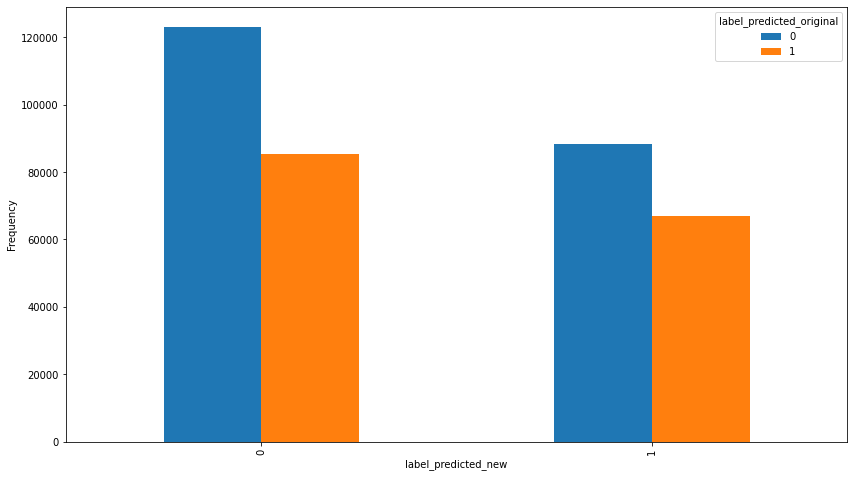

In [19]:
ax = raw_predictions_df.groupby(['label_predicted_original','label_predicted_new'])['label_predicted_original'].count().unstack(0).plot.bar(figsize=(14,8))
_ = ax.set_xlabel('label_predicted_new')
_ = ax.set_ylabel('Frequency')
ax.figure

### predictions_change_df

This CSV is an aggregate of the raw_predictions_df. It introduces a size column, that tells the practitioner the effect of perturbing the value of the raw samples on the predicted output label. For example: {training_type: original_dataset, column_name: age, value_original: x, value_new: -3.0 from the original} has some samples where the predicted output changes, and some samples where it stays the same. Rows of interest might be those where a significant number of predictions change. For example, when it comes to bias and discrimination, a problematic outcome might be a significant proportion of predictions changing simply by modifying sex from Male to Female.

Please have a quick play with this dataset. Again, interactive displays have been included to help draw conclusions

In [20]:
predictions_change_df

,training_type,column_name,value_original,value_new,label_predicted_original,label_predicted_new,size
0,original_dataset,age,x,-3.0 from the original,0,0,378
1,original_dataset,age,x,-3.0 from the original,0,1,285
2,original_dataset,age,x,-3.0 from the original,1,0,235
3,original_dataset,age,x,-3.0 from the original,1,1,164
4,original_dataset,age,x,-6.0 from the original,0,0,373
...,...,...,...,...,...,...,...
230,remove_feature_c_charge_desc,sex,Male,Female,1,1,130
231,remove_feature_c_charge_desc,sex,Male,Male,0,0,228
232,remove_feature_c_charge_desc,sex,Male,Male,0,1,221
233,remove_feature_c_charge_desc,sex,Male,Male,1,0,197


In [21]:
def aggregate_predictions_interact(training_type, column_name):
    return predictions_change_df[
        (predictions_change_df["training_type"] == training_type)
        & (predictions_change_df["column_name"] == column_name)
    ]


interact(
    aggregate_predictions_interact,
    training_type=list(set(predictions_change_df["training_type"].values)),
    column_name=list(set(predictions_change_df["column_name"].values)),
)

interactive(children=(Dropdown(description='training_type', options=('remove_feature_juv_fel_count', 'remove_f…

<function __main__.aggregate_predictions_interact(training_type, column_name)>

**Exercise 5**: After playing around with the data, can you share an example where in the original dataset training type, changing a feature value led to many predictions changing? For that same feature change combination, was there another training type that led to fewer changes in the prediction? The idea here is to mitigate the number of samples changing for features at risk of being discriminatory (_Fairness Through Awareness_ definition of bias).

*Please single (or double) click this box and type your answer here.*

You can also observe the data through a bar plot (or other visualizations, should you wish to plot your own).

The chart below is a way of viewing if the sensitivity analysis had an effect on the output (true if predicted output changed, false otherwise). It is currently broken down by training type, but you can have a play with it and change what column is being used. 

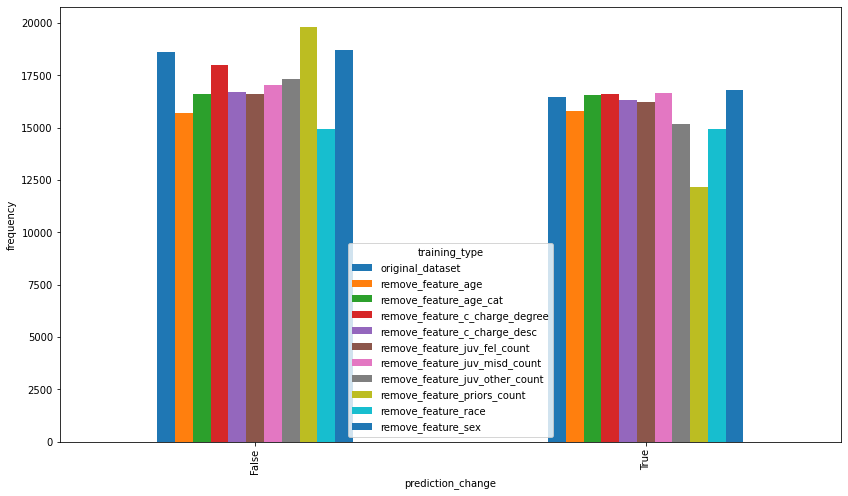

In [22]:
predictions_change_visual_df = predictions_change_df.copy()
predictions_change_visual_df["prediction_change"] = predictions_change_visual_df.label_predicted_original != predictions_change_visual_df.label_predicted_new
ax = predictions_change_visual_df.groupby([
                    "training_type", # try changing this with the feature "column_name", or another feature of your choice                   
                    "prediction_change",
                ])["size"].sum().unstack(0).plot.bar(figsize=(14,8))
_ = ax.set_ylabel('frequency')
ax.figure

## 3.2 Visualizations

This section covers the visualizations that the tool outputs. The visualizations are designed to help inform a practitioner on what kinds of biases might be present in their dataset, and also what the effect is of removing each feature present in the dataset, should the practitioner wish to remove features.
It is important to note that there is a trade-off between these different kinds of fairness and also with model performance. Therefore, a practitioner may want to use the visualizations to observe the effect of satisfying different kinds of fairness, whilst taking model performance into account.

### Analysis 1: Feature Evaluation – Correlation Plot

This visualization is a Pearson’s Correlation for each feature combination of the features in the original dataset. The scale is 0 to 1 (absolute values), where 0 is uncorrelated and 1 is fully correlated. Below you'll be able to see a correlation plot for the features in the dataset: to aid inspection, only values above a threshold of 0.2 are displayed. This visualization is useful for practitioners to observe correlations between features. It might be useful in uncovering features that are proxies for biased features, in order to remove them from the model. This brings us to our final bias definition:


**Fairness through Unawareness**:
In this definition, a model can be considered fair as long as it does not use any input features that are deemed to be protected characteristics (e.g. Race, Sex). This simply involves the practitioner removing discriminatory features from the dataset before the model is even trained.
This is quite popular in practice, as it is quick and straightforward to implement, without needing to compute metrics to evaluate potential biases. For example, Google has removed gender labels from image recognition models, replacing labels referring to _man_ and _woman_ with _person_, with the aim of reducing bias. 
However, the practitioner may want to take this one step further and also remove closely correlated _proxy_ features, as those features may end up being used by the model as an approximation of the removed sensitive features.



In [23]:
analysis_1_compass = f"{output_folder_location}/visualizations/analysis_1"

def show_analysis_1(file=os.listdir(analysis_1_compass)):
    display(Image(f"{analysis_1_compass}/{file}"))

interact(
    lambda x: show_analysis_1(x),
    x=[y for y in os.listdir(analysis_1_compass) if not y.startswith(".")],
)

interactive(children=(Dropdown(description='x', options=('correlation_plot.png',), value='correlation_plot.png…

<function __main__.<lambda>(x)>

**Exercise 6**: Which feature pairs have the highest correlation between them? Given the _Fairness through Unawareness_ definition of bias, would you keep both, one, or neither feature?

*Please single (or double) click this box and type your answer here.*

### Analysis 2: Relative Delta Bias

These visualizations compare the differences in feature value metrics for each feature by training type, computing a feature value delta using the max difference in each of the summary metrics.

In other words:
- For each performance metric (e.g., accuracy, recall)
- For each training type (e.g., all_features, remove_sex)
- For each user-chosen feature that has computed metrics (e.g., a user may choose protected characteristics such as Race and Sex)
- A delta is computed between the maximum and minimum performance of feature values of a feature (i.e., a group).

Linking back to the bias definitions in the section introducing model_evaluation_df, in a truly fair World, metrics such as _equalized_odds_ should be equal among all groups for a given feature. I.e., the _equalized_odds_delta_ should be 0, as that implies that all groups have the same value.

A practitioner will want to use this data to select a training type that leads to the lowest relative delta values for a given performance or bias metric. In practice, it may be hard to find an optimal training type that is the minimum delta for all metrics.

The sketches below are grouped by feature, and have two display modes: stacked or small multiples. Double clicking on visualizations will make it zoom in, which might make the graph more readable.

In [24]:
analysis_2_compass = f"{output_folder_location}/visualizations/analysis_2_and_3_ml_models/analysis_2_relative_delta_bias/"

def show_analysis_2(file=os.listdir(analysis_2_compass)):
    display(Image(f"{analysis_2_compass}/{file}"))

interact(
    lambda x: show_analysis_2(x),
    x=[y for y in os.listdir(analysis_2_compass) if not y.startswith(".")],
)

interactive(children=(Dropdown(description='x', options=('age_cat_small_multiples.png', 'sex_small_multiples.p…

<function __main__.<lambda>(x)>

**Exercise 7**: For variable statistical_party_delta, and feature sex, which training type results in the lowest delta metric? Is this an improvement over the original dataset training type? For the definition of statistical_parity_delta, is this dataset now fair?

*Please single (or double) click this box and type your answer here.*

**Exercise 8**: The 4 bias metrics displayed here are equalized odds, equal opportunity, statistical parity and treatment equality. Out of these bias types, are there any that you are likely to use for this kind of dataset? How did you decide which to use?

*Please single (or double) click this box and type your answer here.*

### Analysis 3: Absolute Delta Bias

This visualization looks at the effect of training type on the same feature value for each evaluation metric. The least biased training option for a feature value can be considered the one with the highest values in the performance metrics.

Whilst Analysis 2 looks at the between-feature value effects of different training methods, aiming to minimize the discrepancies in metrics between feature values, Analysis 3 looks at the within-feature value effects of different training types, when compared to the original dataset. In other words, this analysis tells a practitioner if performing a certain modification on the original dataset leads to an improvement in metrics: a positive delta suggests an improvement, whilst a negative value means that the new training method is worse than the original one.

In [25]:
analysis_3_compass = f"{output_folder_location}/visualizations/analysis_2_and_3_ml_models/analysis_3_absolute_delta_bias"

def show_analysis_3(file=os.listdir(analysis_3_compass)):
    display(Image(f"{analysis_3_compass}/{file}"))

interact(
    lambda x: show_analysis_3(x),
    x=[y for y in os.listdir(analysis_3_compass) if not y.startswith(".")],
)

interactive(children=(Dropdown(description='x', options=('race_african_american_small_multiples.png', 'race_ot…

<function __main__.<lambda>(x)>

**Exercise 9**: For variable equalized_odds_delta, and feature value African American (race), which training type results in the biggest improvement in score? If you chose this training type, how does it affect the equalized_odds_delta of feature value Caucasian (race)?

*Please single (or double) click this box and type your answer here.*

### Analysis 4: Prediction Change

These visualizations look at the effect of training type on the ratio of samples changing output, for a given sensitive feature and feature value. Based on the bias definitions introduced in raw_predictions_df, the least biased training option for a feature value can be considered the one with the lowest number of samples changing output when that feature value is modified.

In the visualization, any training methods with a lower ratio than the original (all_features) signifies an improvement in bias prevention, whilst a higher ratio signifies that the original training method is better.

In [26]:
analysis_4_compass = f"{output_folder_location}/visualizations/analysis_4_and_5_sensitivity/analysis_4_prediction_change"

def show_analysis_4(file=os.listdir(analysis_4_compass)):
    display(Image(f"{analysis_4_compass}/{file}"))
    
interact(
    lambda x: show_analysis_4(x),
    x=[y for y in os.listdir(analysis_4_compass) if not y.startswith(".")],
)

interactive(children=(Dropdown(description='x', options=('race_other_stacked_visualization.png', 'age_x_stacke…

<function __main__.<lambda>(x)>

**Exercise 10**: Pick a feature value, and write down which training type leads to the lowest ratio of prediction changes, and which leads to the highest ratio.

*Please single (or double) click this box and type your answer here.*

### Analysis 5: Prediction Volatility

These visualizations are very similar to those shown in Analysis 4, however, instead of looking at prediction changes, they look at changes in the prediction probabilities. The least biased training option for a feature value can be considered the one with the lowest changes in the size of probability outputs when that feature value is modified.

In [27]:
analysis_5_compass = f"{output_folder_location}/visualizations/analysis_4_and_5_sensitivity/analysis_5_prediction_volatility"

def show_analysis_5(file=os.listdir(analysis_5_compass)):
    display(Image(f"{analysis_5_compass}/{file}"))

interact(
    lambda x: show_analysis_5(x),
    x=[y for y in os.listdir(analysis_5_compass) if not y.startswith(".")],
)

interactive(children=(Dropdown(description='x', options=('race_other_stacked_visualization.png', 'age_x_stacke…

<function __main__.<lambda>(x)>

**Exercise 11**: Looking at the same feature value that you picked in Exercise 10, has the training type that led to the lowest ratio of prediction changes, and the one that led to the highest ratio changed? If so, what are they now?

*Please single (or double) click this box and type your answer here.*

___
### End of the main part of the study
You have now completed the main part of the study. There is an optional exercise below that invites you to apply concepts of bias to a new dataset, should you wish to spend more time learning about bias.

If you decide to end the study here, please make sure to **manually save the Notebook** (if you click on _file_ in the top left of the menu bar, there is an option to _save_), and share it with the researchers (also in _file_, click _download_ and select the _.ipynb_ format. You will then be invited to take part in a follow-up interview.

___

# 4. OPTIONAL Exploration Exercise with a new Dataset

The previous sections introduced you to concepts of bias through a tool developed for this study. It followed a dataset called COMPAS Recidivism Dataset. The following **optional** section is meant to be exploratory: it is meant to get you to think about bias in ML. 

**Exercise 12**: Please try the tool yourself on the following dataset: german credit. This is a popular dataset used for research within the Bias community. Boilerplate code is provided below to help compute the analysis. You are also free to try it on a dataset of your choice, should you prefer to do so.

- Please run the analysis and observe the results.
- Feel free to implement your own additional code based on other parts of the tutorial or your own knowledge, e.g., to help with visualizing the data, or with understanding bias, or to improve the ML model by trying other parameters. Feel free to add more code boxes using the + button at the top menu of the Notebook. 
- Please write down a few (at least 3) interesting insights that would help you in model building (e.g., switching training type to remove feature x results in a lower bias for feature y). Feel free to write answers in the space provided _below_.
- Think about the different bias metrics (introduced in this tutorial or from your own research or knowledge). Which would you use and why?

When you are done exploring, please save the Notebook and share it with the researchers. You will then be invited to take part in a follow-up interview.

Run the code below to compile the analysis. This is the skeleton code intended to get the tool to compute the analysis, but feel free to add additional code

In [28]:
# Variables refering to folder locations for the German Credit dataset are defined here
"""
Provide the path to the dataset
"""
german_dataset_csv_path = "scripts/data/3_german_credit/german_credit_data.csv"

"""
Provide a list of columns that need to be removed from the dataset in the pre-processing stage
"""
german_dataset_columns_to_remove = Helper.read_yaml("scripts/data/3_german_credit/columns_to_remove.yml")

"""
The desired location of the analysis output. These can be accessed at a later stage, 
to avoid having to re-run everything.
"""
german_output_folder_location = "scripts/data/3_german_credit/output"

In [29]:
# Load and clean the dataset
def clean_dataset(csv_path, columns_to_remove):
    # The dataset used is taken from https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
    df = pd.read_csv(csv_path, index_col=0)

    # get rid of columns that shouldn't be in the input model
    filtered_columns_to_remove = df.filter(columns_to_remove)
    df.drop(filtered_columns_to_remove, inplace=True, axis=1)

    # lowercase + underscore for columns
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ", "_")

    # map output to integer values
    df["risk"].replace({"bad": 0, "good": 1}, inplace=True)

    # Ensure validity of inputs – No NaNs
    object_list, numeric_list = Helper.get_df_types_list(df)
    for column in object_list:
        df[column].fillna("", inplace=True)
    for column in numeric_list:
        df[column].fillna(-1, inplace=True)

    return df

german_credit_df = clean_dataset(german_dataset_csv_path, german_dataset_columns_to_remove)
german_credit_df

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,,1736,12,furniture/equipment,1
996,40,male,3,own,little,little,3857,30,car,1
997,38,male,2,own,little,,804,12,radio/TV,1
998,23,male,2,free,little,little,1845,45,radio/TV,0


Here is a brief explanation of each feature:
- age: ranges from 19 to 75
- sex: male or female
- job: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled
- housing: own, rent, or free
- savings_accounts: amount of money in the account: unknown (empty entry), little, moderate, quite rich, rich
- checking_account: amount of money in the account: unknown (empty entry), little, moderate, quite rich, rich
- credit_amount: between 250 and 18424 Deutsch Mark (DM)
- duration: how long the loan is taken out for. Ranges between 4 and 72 months
- purpose: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
- risk (output feature): good or bad credit risks. 1 is good credit risk, 0 is bad credit risk.

In [30]:
# Define the following parameters for the tool
german_training_types = [
        "original_dataset",
        "remove_feature",
    ]
german_features_of_interest = ["age", "sex"]
german_output = "risk"
german_unique_values = 10
german_verbose = False

In [31]:
# Parameters for the trained Neural Network model. You can optionally modify them if you choose to, but it is not necessary.
german_best_params = dict(
    batch_size=256,
    epochs=15,
    optimizer="Adam",
    init_mode="he_uniform",
    activation="relu",
    weight_constraint=3,
    dropout_rate=0.1,
    neurons=64,
    hidden_layers=2,
)

In [32]:
# Running the analysis itself
(
    german_model_evaluation_df,
    german_raw_predictions_df,
    german_predictions_change_df,
    german_volatility_df,
    german_sensitivity_evaluation_df,
) = CompileModelAndAnalysis(
    german_training_types,
    german_features_of_interest,
    german_output,
    german_dataset_columns_to_remove,
    german_dataset_csv_path,
    None,
    german_unique_values,
    german_best_params,
).main(
    german_credit_df
)

RUNNING ANALYSIS FOR TRAINING TYPE: 'original_dataset'

List of numeric features for this dataset: ['age', 'job', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 115ms/step - loss: 0.8834 - accuracy: 0.4469 - val_loss: 0.6906 - val_accuracy: 0.6125
Epoch 2/15
3/3 [==============================] - 0s 10ms/step - loss: 0.7345 - accuracy: 0.5781 - val_loss: 0.6398 - val_accuracy: 0.6812
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6908 - accuracy: 0.6406 - val_loss: 0.6280 - val_accuracy: 0.7000
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6790 - accuracy: 0.6609 - val_loss: 0.6106 - val_accuracy: 0.7063
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   28.8s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   35.7s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   35.9s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   39.8s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_age'

List of numeric features for this dataset: ['job', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 117ms/step - loss: 0.8253 - accuracy: 0.4828 - val_loss: 0.7323 - val_accuracy: 0.5813
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.7208 - accuracy: 0.5891 - val_loss: 0.7030 - val_accuracy: 0.6313
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6676 - accuracy: 0.6453 - val_loss: 0.6894 - val_accuracy: 0.6687
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6302 - accuracy: 0.6891 - val_loss: 0.6774 - val_accuracy: 0.6875
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.603

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   29.9s remaining:   49.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   30.1s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   34.4s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_sex'

List of numeric features for this dataset: ['age', 'job', 'credit_amount', 'duration']
List of non-numeric features: ['housing', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 106ms/step - loss: 0.9101 - accuracy: 0.4484 - val_loss: 0.7267 - val_accuracy: 0.6125
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.7374 - accuracy: 0.5813 - val_loss: 0.6849 - val_accuracy: 0.6562
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6815 - accuracy: 0.6516 - val_loss: 0.6823 - val_accuracy: 0.7000
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6503 - accuracy: 0.6641 - val_loss: 0.6833 - val_accuracy: 0.6875
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.634

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   41.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   41.7s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   49.5s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_job'

List of numeric features for this dataset: ['age', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 114ms/step - loss: 0.7833 - accuracy: 0.4859 - val_loss: 0.7149 - val_accuracy: 0.5500
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.7096 - accuracy: 0.5750 - val_loss: 0.6680 - val_accuracy: 0.6313
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6578 - accuracy: 0.6734 - val_loss: 0.6362 - val_accuracy: 0.6938
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6345 - accuracy: 0.7094 - val_loss: 0.6069 - val_accuracy: 0.7000
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.603

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   38.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   39.8s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   47.2s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_housing'

List of numeric features for this dataset: ['age', 'job', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 109ms/step - loss: 0.7531 - accuracy: 0.5609 - val_loss: 0.6687 - val_accuracy: 0.6187
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6987 - accuracy: 0.6484 - val_loss: 0.6401 - val_accuracy: 0.6438
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6545 - accuracy: 0.6687 - val_loss: 0.6178 - val_accuracy: 0.6562
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6266 - accuracy: 0.6812 - val_loss: 0.6019 - val_accuracy: 0.6625
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.601

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   38.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   38.5s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   43.9s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_saving_accounts'

List of numeric features for this dataset: ['age', 'job', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'housing', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 107ms/step - loss: 0.6380 - accuracy: 0.6516 - val_loss: 0.6981 - val_accuracy: 0.6562
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.5924 - accuracy: 0.6906 - val_loss: 0.6794 - val_accuracy: 0.6750
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.5856 - accuracy: 0.6875 - val_loss: 0.6539 - val_accuracy: 0.6812
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.5749 - accuracy: 0.7047 - val_loss: 0.6314 - val_accuracy: 0.6750
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.550

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   35.6s remaining:   59.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   36.9s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   42.9s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_checking_account'

List of numeric features for this dataset: ['age', 'job', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 105ms/step - loss: 0.9485 - accuracy: 0.4500 - val_loss: 0.7746 - val_accuracy: 0.5500
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.7563 - accuracy: 0.5906 - val_loss: 0.6257 - val_accuracy: 0.7125
Epoch 3/15
3/3 [==============================] - 0s 10ms/step - loss: 0.6723 - accuracy: 0.6578 - val_loss: 0.5641 - val_accuracy: 0.7375
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6480 - accuracy: 0.6641 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   35.0s remaining:   58.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   36.0s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   42.9s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_credit_amount'

List of numeric features for this dataset: ['age', 'job', 'duration']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 114ms/step - loss: 0.8093 - accuracy: 0.5734 - val_loss: 0.6545 - val_accuracy: 0.6375
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.7397 - accuracy: 0.5891 - val_loss: 0.6042 - val_accuracy: 0.7000
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6637 - accuracy: 0.6281 - val_loss: 0.5627 - val_accuracy: 0.7250
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6744 - accuracy: 0.6187 - val_loss: 0.5365 - val_accuracy: 0.7375
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.633

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   35.2s remaining:   58.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   35.7s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   42.4s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_duration'

List of numeric features for this dataset: ['age', 'job', 'credit_amount']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 113ms/step - loss: 0.6520 - accuracy: 0.6719 - val_loss: 0.6901 - val_accuracy: 0.6438
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6213 - accuracy: 0.6984 - val_loss: 0.6602 - val_accuracy: 0.6562
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6054 - accuracy: 0.6984 - val_loss: 0.6349 - val_accuracy: 0.6625
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.5858 - accuracy: 0.7031 - val_loss: 0.6143 - val_accuracy: 0.6625
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.587

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   38.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   39.6s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   43.6s finished


RUNNING ANALYSIS FOR TRAINING TYPE: 'remove_feature_purpose'

List of numeric features for this dataset: ['age', 'job', 'credit_amount', 'duration']
List of non-numeric features: ['sex', 'housing', 'saving_accounts', 'checking_account']

Total number of training samples: 640
Total number of validation samples: 160
Total number of test samples: 200

Training the model:
Epoch 1/15
3/3 [==============================] - 1s 106ms/step - loss: 0.6582 - accuracy: 0.6062 - val_loss: 0.5725 - val_accuracy: 0.7063
Epoch 2/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6255 - accuracy: 0.6516 - val_loss: 0.5373 - val_accuracy: 0.7312
Epoch 3/15
3/3 [==============================] - 0s 9ms/step - loss: 0.6080 - accuracy: 0.6797 - val_loss: 0.5217 - val_accuracy: 0.7437
Epoch 4/15
3/3 [==============================] - 0s 9ms/step - loss: 0.5877 - accuracy: 0.7078 - val_loss: 0.5130 - val_accuracy: 0.7437
Epoch 5/15
3/3 [==============================] - 0s 9ms/step - loss: 0.572

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   35.2s remaining:   58.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   36.1s remaining:   21.6s



Data Computation Phase Completed Successfully.



[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   37.6s finished


In [33]:
# Saving the computed datasets. These are used in the analysis part of the tool
german_model_evaluation_df.round(2).to_csv(
    f"{german_output_folder_location}/ml_models_evaluation.csv", index=False,
)
german_raw_predictions_df.round(2).to_csv(
    f"{german_output_folder_location}/sensitivity_predictions_raw.csv", index=False,
)
german_predictions_change_df.round(2).to_csv(
    f"{german_output_folder_location}/sensitivity_predictions_change.csv", index=False,
)
german_volatility_df.round(2).to_csv(
    f"{german_output_folder_location}/sensitivity_predictions_volatility.csv", index=False,
)
german_sensitivity_evaluation_df.round(2).to_csv(
    f"{german_output_folder_location}/sensitivity_output_evaluation.csv", index=False,
)

In [34]:
# Run tool interaction
RunInteraction(german_dataset_csv_path, german_output, german_output_folder_location, german_verbose).main(german_credit_df)

Creating visualizations based on the computed datasets.

Creating correlation plot.

Creating delta bias plots.

Creating sensitivity analysis plots.

Visualization creation completed.



For the next part, have a look at the computed analysis. Feel free to refer to the analysis section of the tutorial for inspiration on what you can look out for.

Feel free to also manually open the CSV and image files for this dataset. They are located under: ``ml_bias_explainability/scripts/data/3_german_credit``. The input dataset is called ``german_credit_data.csv`` and the output files are located inside the ``output`` folder.

In [35]:
# Space to add own code. Feel free to add more code boxes using the "+ Code" button at the top menu of the Notebook. 
# Feel free to write answers using Markdown, this can be done by using the "+ Text" buton at the top menu of the Notebook.